Copyright (c) 2019 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book-3rd-edition

[MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Python. Uczenie maszynowe - kod źródłowy

# Rozdział 6. Najlepsze metody oceny modelu i strojenie parametryczne

Zwróć uwagę, że rozszerzenie zawierające nieobowiązkowy znak wodny stanowi niewielki plugin notatnika IPython / Jupyter, który zaprojektowałem w celu powielania kodu źródłowego. Wystarczy pominąć poniższe wiersze kodu:

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka" -u -d -v -p numpy,pandas,matplotlib,sklearn

Sebastian Raschka 
last updated: 2020-03-04 

CPython 3.7.1
IPython 7.12.0

numpy 1.18.1
pandas 1.0.1
matplotlib 3.1.0
sklearn 0.22


*Korzystanie z rozszerzenia `watermark` nie jest obowiązkowe. Możesz je zainstalować za pomocą polecenia:*  

    conda install watermark -c conda-forge  

lub  

    pip install watermark   

*Więcej informacji znajdziesz pod adresem: https://github.com/rasbt/watermark.*

<br>
<br>

### Spis treści

- [Usprawnianie cyklu pracy za pomocą kolejkowania](#Usprawnianie-cyklu-pracy-za-pomocą-kolejkowania)
  - [Wczytanie zestawu danych Breast Cancer Wisconsin](#Wczytanie-zestawu-danych-Breast-Cancer-Wisconsin)
  - [Łączenie funkcji transformujących i estymatorów w kolejce czynności](#Łączenie-funkcji-transformujących-i-estymatorów-w-kolejce-czynności)
- [Stosowanie k-krotnego sprawdzianu krzyżowego w ocenie skuteczności modelu](#Stosowanie-k-krotnego-sprawdzianu-krzyżowego-w-ocenie-skuteczności-modelu)
  - [Metoda wydzielania](#Metoda-wydzielania)
  - [K-krotny sprawdzian krzyżowy](#K-krotny-sprawdzian-krzyżowy)
- [Sprawdzanie algorytmów za pomocą krzywych uczenia i krzywych walidacji](#Sprawdzanie-algorytmów-za-pomocą-krzywych-uczenia-i-krzywych-walidacji)
  - [Diagnozowanie problemów z obciążeniem i wariancją za pomocą krzywych uczenia](#Diagnozowanie-problemów-z-obciążeniem-i-wariancją-za-pomocą-krzywych-uczenia)
  - [Rozwiązywanie problemów przetrenowania i niedotrenowania za pomocą krzywych walidacji](#Rozwiązywanie-problemów-przetrenowania-i-niedotrenowania-za-pomocą-krzywych-walidacji)
- [Dostrajanie modeli uczenia maszynowego za pomocą metody przeszukiwania siatki](#Dostrajanie-modeli-uczenia-maszynowego-za-pomocą-metody-przeszukiwania-siatki)
  - [Strojenie hiperparametrów przy użyciu metody przeszukiwania siatki](#Strojenie-hiperparametrów-przy-użyciu-metody-przeszukiwania-siatki)
  - [Dobór algorytmu poprzez zagnieżdżony sprawdzian krzyżowy](#Dobór-algorytmu-poprzez-zagnieżdżony-sprawdzian-krzyżowy)
- [Przegląd wskaźników oceny skuteczności](#Przegląd-wskaźników-oceny-skuteczności)
  - [Odczytywanie macierzy pomyłek](#Odczytywanie-macierzy-pomyłek)
  - [Optymalizacja precyzji i pełności modelu klasyfikującego](#Optymalizacja-precyzji-i-pełności-modelu-klasyfikującego)
  - [Wykres krzywej ROC](#Wykres-krzywej-ROC)
  - [Wskaźniki zliczające dla klasyfikacji wieloklasowej](#Wskaźniki-zliczające-dla-klasyfikacji-wieloklasowej)
- [Kwestia dysproporcji klas](#Kwestia-dysproporcji-klas)
- [Podsumowanie](#Podsumowanie)

<br>
<br>

In [1]:
from IPython.display import Image
%matplotlib inline

# Usprawnianie cyklu pracy za pomocą kolejkowania

...

## Wczytanie zestawu danych Breast Cancer Wisconsin

In [3]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

# jeżeli zestaw danych Breast Cancer będzie tymczasowo niedostępny w
# repozytorium UCI, usuń znak komentarza z poniższego wiersza, aby wczytać ten
# zestaw z katalogu lokalnego:

# df = pd.read_csv('wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.shape

(569, 32)

<hr>

In [5]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [6]:
le.transform(['M', 'B'])

array([1, 0])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

<br>
<br>

## Łączenie funkcji transformujących i estymatorów w kolejce czynności

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1, solver='lbfgs'))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Dokładność dla danych testowych: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


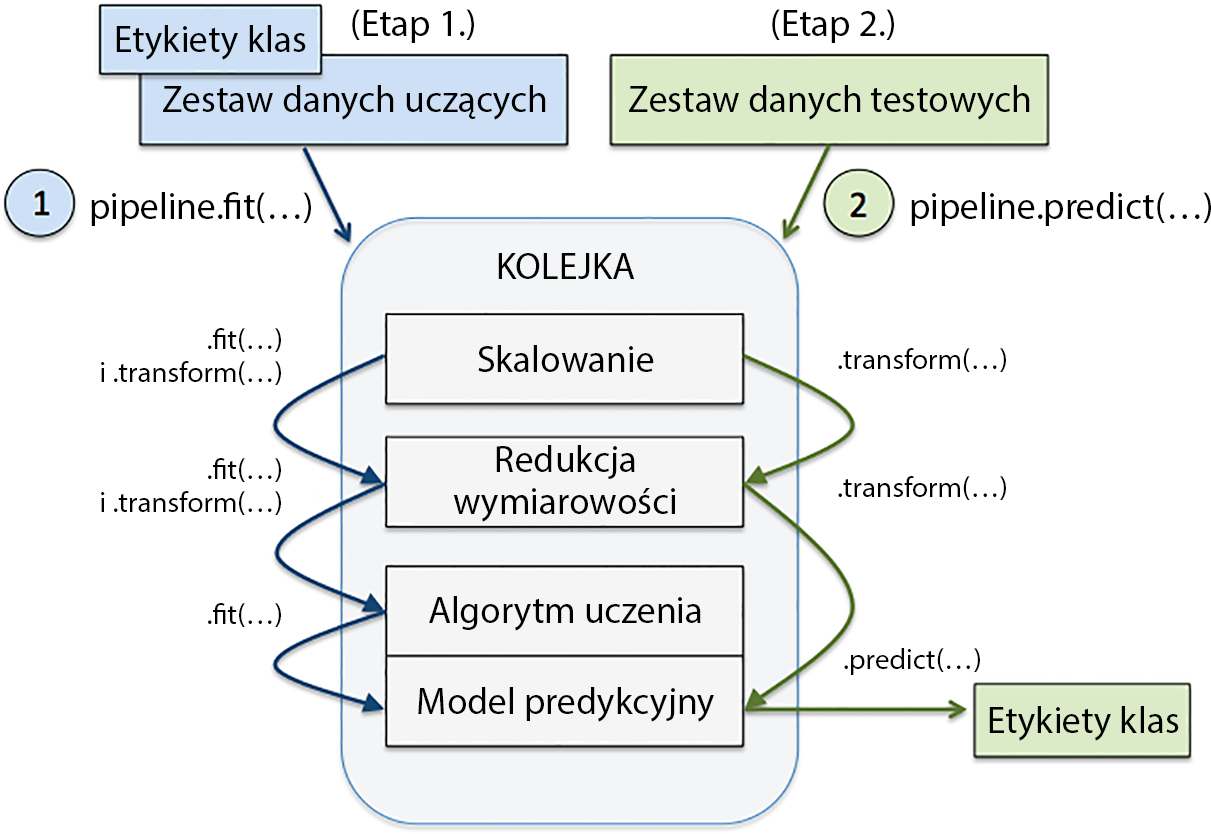

In [2]:
Image(filename='rysunki/06_01.png', width=500) 

<br>
<br>

# Stosowanie k-krotnego sprawdzianu krzyżowego w ocenie skuteczności modelu

...

## Metoda wydzielania

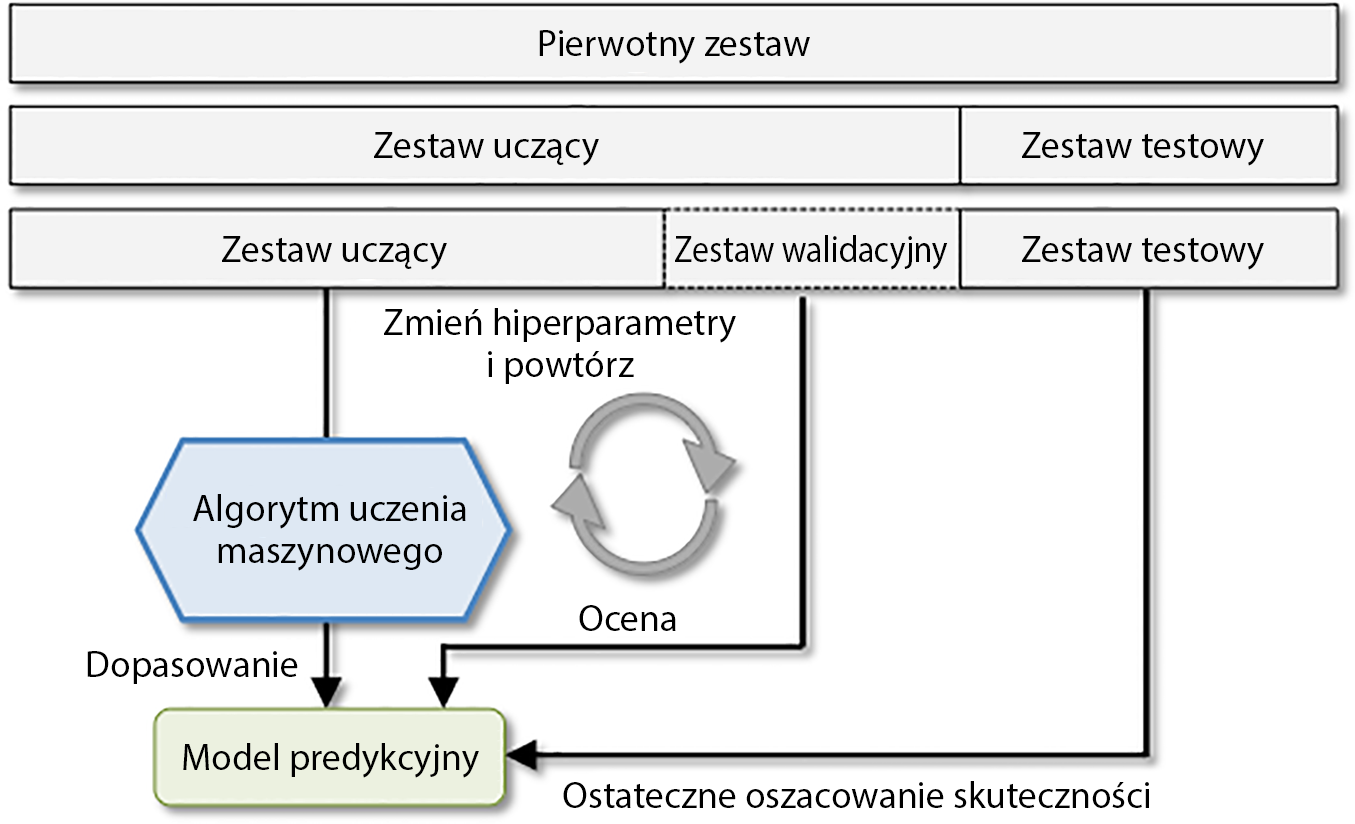

In [3]:
Image(filename='rysunki/06_02.png', width=500) 

<br>
<br>

## K-krotny sprawdzian krzyżowy

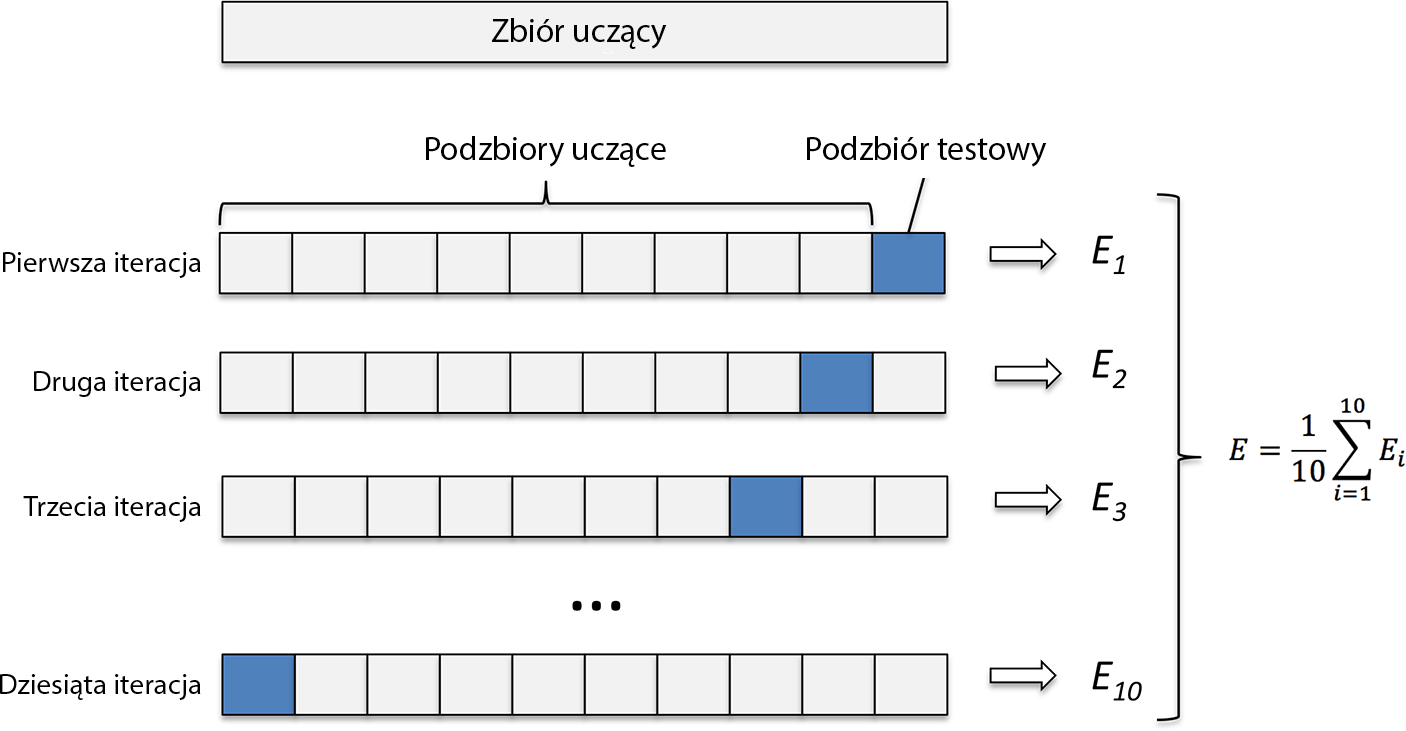

In [4]:
Image(filename='rysunki/06_03.png', width=500) 

In [12]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
    

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Podzbiór: %2d, Rozkład klasy: %s, Dokładność: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nDokładność sprawdzianu: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.014


In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('Wyniki dokładności sprawdzianu: %s' % scores)
print('Dokładność sprawdzianu: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


<br>
<br>

# Sprawdzanie algorytmów za pomocą krzywych uczenia i krzywych walidacji

<br>
<br>

## Diagnozowanie problemów z obciążeniem i wariancją za pomocą krzywych uczenia

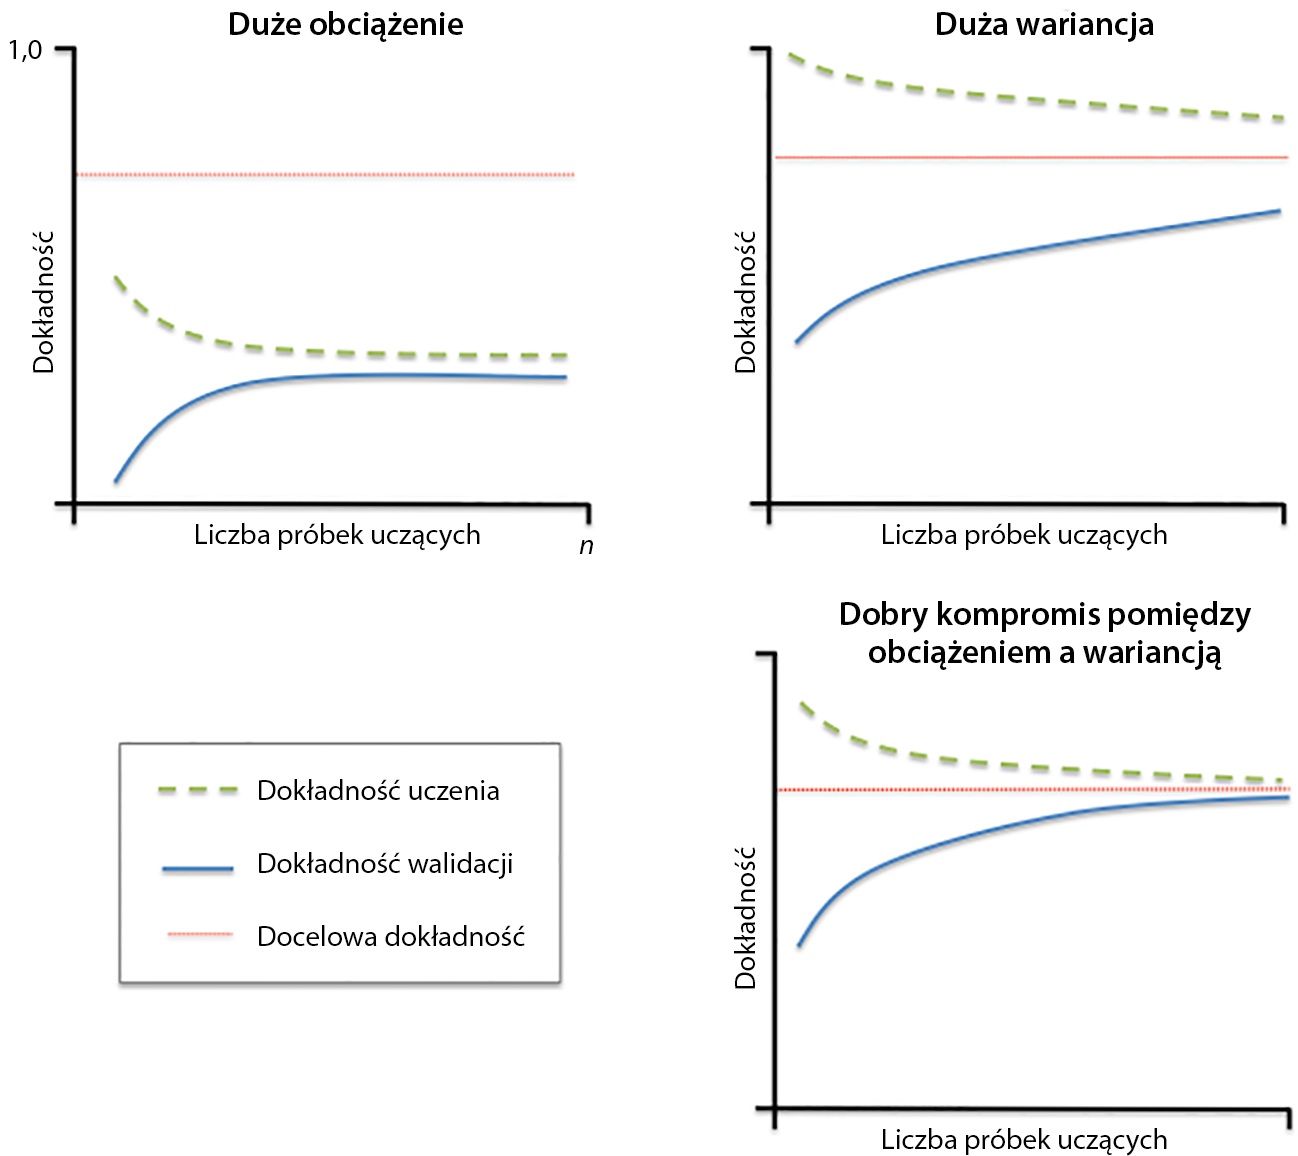

In [5]:
Image(filename='rysunki/06_04.png', width=600) 

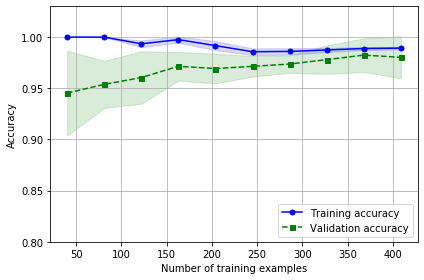

In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1,
                                           solver='lbfgs', max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Dokładność uczenia')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Dokładność walidacji')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Liczba przykładów uczących')
plt.ylabel('Dokładność')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('rysunki/06_05.png', dpi=300)
plt.show()

<br>
<br>

## Rozwiązywanie problemów przetrenowania i niedotrenowania za pomocą krzywych walidacji

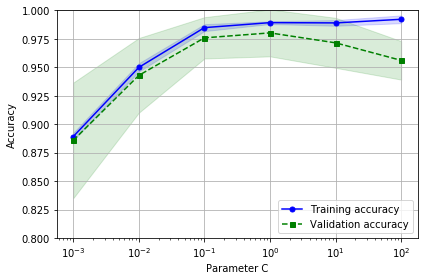

In [16]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Dokładność uczenia')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Dokładność walidacji')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parametr C')
plt.ylabel('Dokładność')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('rysunki/06_06.png', dpi=300)
plt.show()

<br>
<br>

# Dostrajanie modeli uczenia maszynowego za pomocą metody przeszukiwania siatki

<br>
<br>

## Strojenie hiperparametrów przy użyciu metody przeszukiwania siatki

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [18]:
clf = gs.best_estimator_

# clf.fit(X_train, y_train) 
# zwróć uwagę, że nie musimy ponownie dopasowywać klasyfikatora,
# ponieważ proces ten jest realizowany automatycznie za pomocą argumentu refit=True.

print('Dokładność dla zbioru testowego: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


<br>
<br>

## Dobór algorytmu poprzez zagnieżdżony sprawdzian krzyżowy

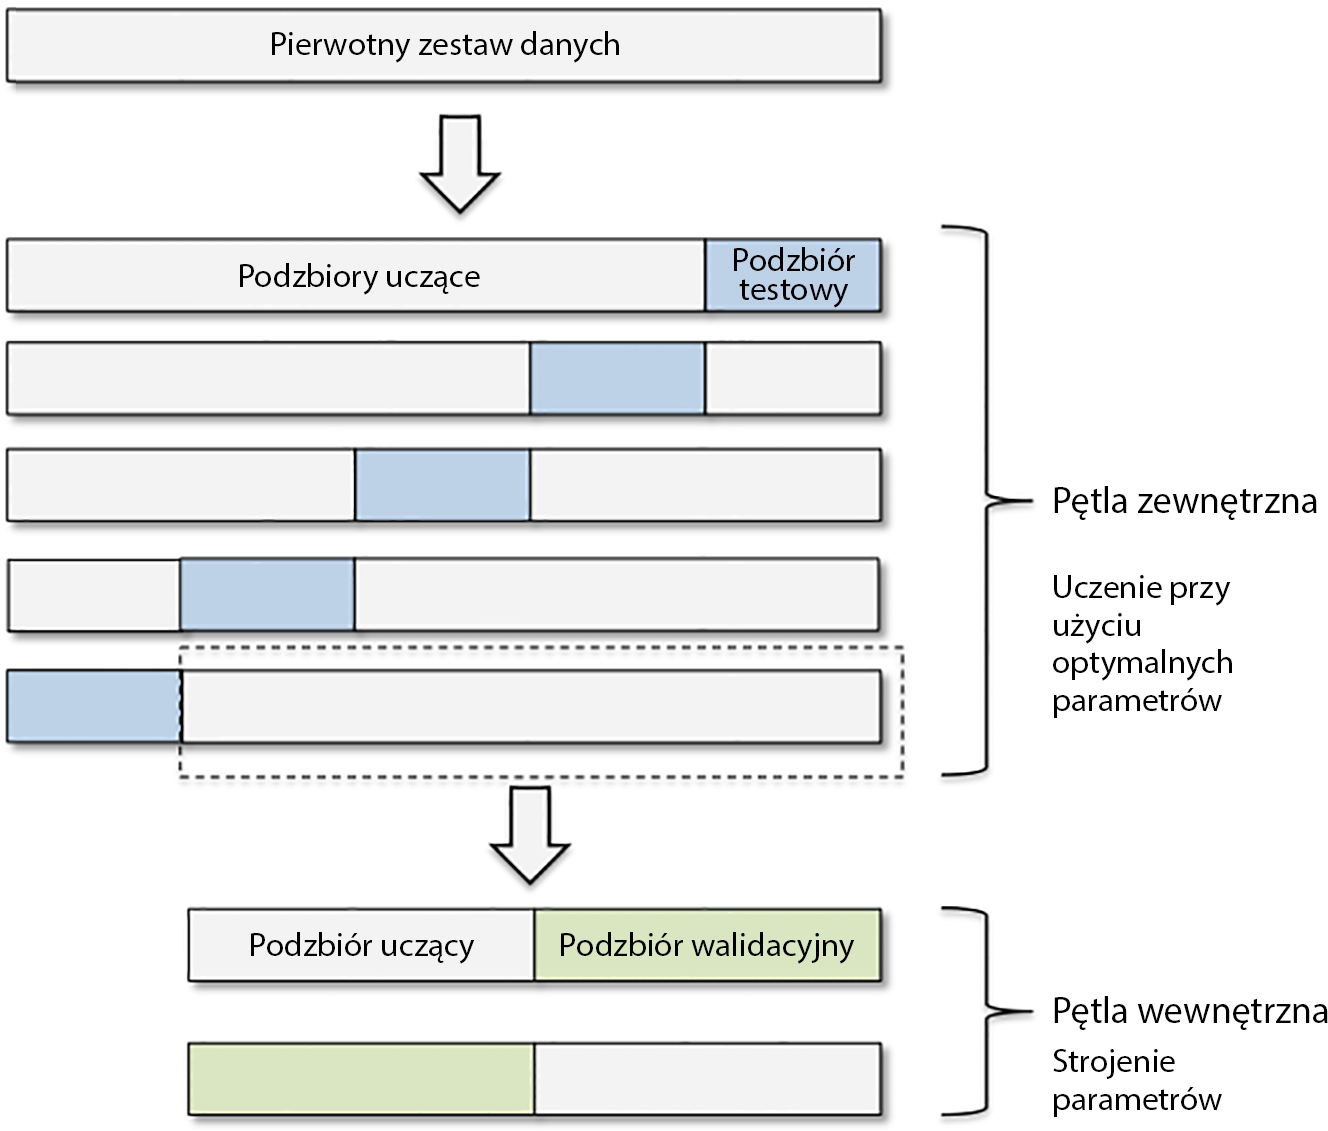

In [6]:
Image(filename='rysunki/06_07.png', width=500) 

In [20]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('Dokładność sprawdzianu krzyżowego: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV accuracy: 0.974 +/- 0.015


In [21]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('Dokładność sprawdzianu krzyżowego: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV accuracy: 0.934 +/- 0.016


<br>
<br>

# Przegląd wskaźników oceny skuteczności

...

## Odczytywanie macierzy pomyłek

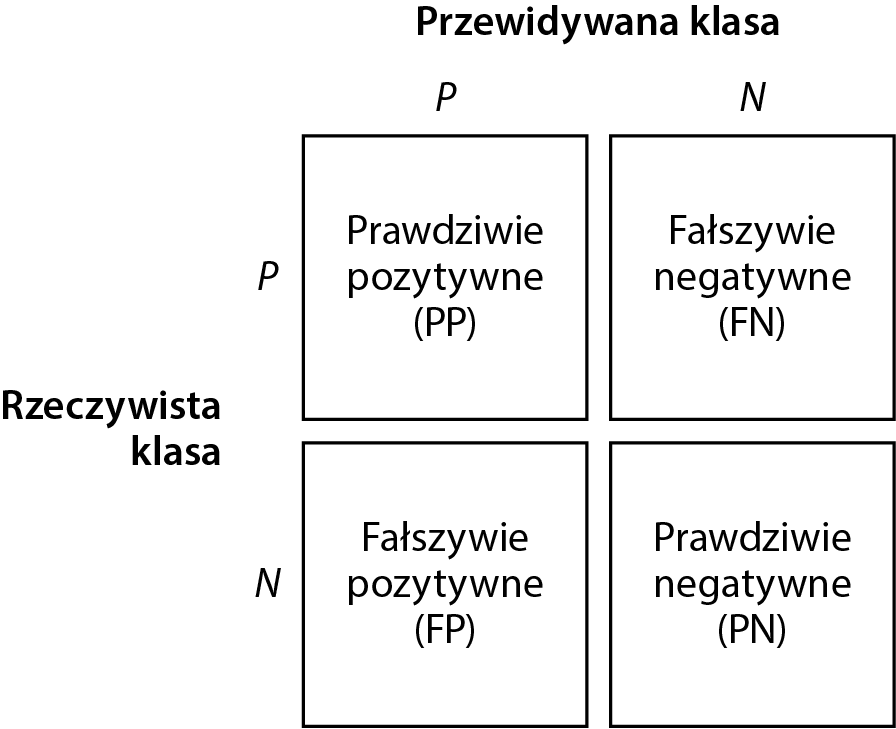

In [7]:
Image(filename='rysunki/06_08.png', width=300) 

In [23]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


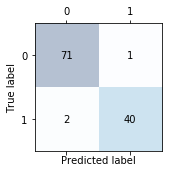

In [24]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Przewidywana etykieta')
plt.ylabel('Rzeczywista etykieta')

plt.tight_layout()
#plt.savefig('rysunki/06_09.png', dpi=300)
plt.show()

### Dodatkowa uwaga

Przypominam, że na początku rozdziału zakodowaliśmy etykiety klas w taki sposób, że przykłady *złośliwe* należą do klasy "pozytywnej" (1), a przykłady *łagodne* do klasy "negatywnej" (0):

In [25]:
le.transform(['M', 'B'])

array([1, 0])

In [26]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


Następnie wyświetliliśmy macierz pomyłek w następujący sposób:

In [27]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


Zwróć uwagę, że (prawdziwe) przykłady klasy 0 poprawnie sklasyfikowane jako klasa 0 (prawdziwie negatywne) znajdują się teraz w lewym górnym rogu macierzy (indeks 0,0). Aby zmienić kolejność wyświetlania komórek, tak aby prawdziwie negatywne znajdowały się w prawym dolnym rogu tabeli (indeks 1,1), a prawdziwie pozytywne w jej lewej górnej części, możemy użyć argumentu `labels`:

In [28]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

[[40  2]
 [ 1 71]]


Podsumowując:

Zakładając w tym przykładzie, że klasa 1 (nowotwory złośliwe) jest pozytywna, nasz model poprawnie sklasyfikował 71 przykładów należących do klasy 0 (prawdziwie negatywne) oraz 40 przykładów do klasy 1 (prawdziwie pozytywne). Jednocześnie jednak jeden przykład z klasy 0 został nieprawidłowo sklasyfikowany do klasy 1 (fałszywie pozytywny) oraz model przewidział, że dwa przykłady są łagodne, pomimo że w rzeczywistości reprezentują nowotwór złośliwy (fałszywie negatywne).

<br>
<br>

## Optymalizacja precyzji i pełności modelu klasyfikującego

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precyzja: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Pełność: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [30]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


<br>
<br>

## Wykres krzywej ROC

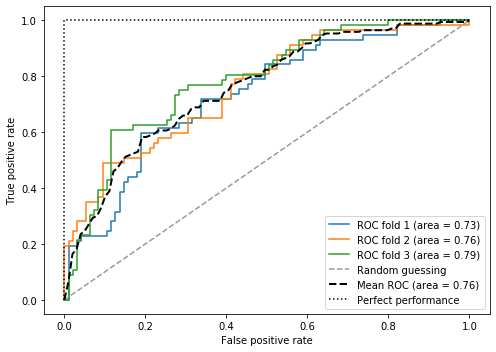

In [31]:
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='Podzbiór nr %d (obszar = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Losowe zgadywanie')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Uśredniona krzywa ROC (obszar = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Doskonała skuteczność')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('rysunki/06_10.png', dpi=300)
plt.show()

<br>
<br>

## Wskaźniki zliczające dla klasyfikacji wieloklasowej

In [32]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')

# Kwestia dysproporcji klas

In [33]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [34]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [35]:
from sklearn.utils import resample

print('Liczba przykładów z klasy 1. przed przepróbkowaniem:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('Liczba przykładów z klasy 1. po przepróbkowaniu:', X_upsampled.shape[0])

Number of class 1 examples before: 40
Number of class 1 examples after: 357


In [36]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [37]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

<br>
<br>

# Podsumowanie

...

---

Czytelnicy mogą zignorować poniższą komórkę.

In [38]:
! python ../.convert_notebook_to_script.py --input r06.ipynb --output r06.py

[NbConvertApp] Converting notebook ch06.ipynb to script
[NbConvertApp] Writing 17510 bytes to ch06.py
